In [3]:
import numpy as np
import healpy as hp
import math
import matplotlib.pyplot as plt

%matplotlib inline

from astropy.io import fits
from statistics import mean
from scipy.optimize import curve_fit
from astropy_healpix import HEALPix
from tqdm import tqdm
from scipy.optimize import fsolve

# HEALPY Math (Unimportant) vvv

MATH\
$n=\sqrt{\frac{len(array)}{12}}$\
l=total length of chain= $2n+1$ [(4,8,12,16,16,16,16,16,16,16,16,16,12,8,4); l=9]\
N=total number of rows=(4n-1) [above,n=4,#rows=15]\
S=total sum=$12n^2$\
lt=thickness of each row in degrees=180/N (above, N=15, lt=180/15=12)\
s=number of rows from lat=0= ROUND UP: s=desired region cut out/lt\
index=$len(array)-(2n(n-1)+4n(n-s))$\ <-- iff s<=n\
th=thickness=(2s+1)*(4n)

Real stuff vvv

# Data

fornengo files

"lambda_DRAO_22MHz_1_256.fits",22,"G",False\
"MAIPU_MU_1_64.fits",45,"G",False\
"haslam408_dsds_Remazeilles2014.fits",408,"G",False\
"Dwingeloo_Kelvins_1_256.fits",820,"G",False\
"STOCKERT+VILLA-ELISA_1420MHz_1_256.fits",1420,"G",False\
"lambda_23de_hea.fits",2326,"C",False\

LWA files

"LWA Files/healpix-all-sky-rav-wsclean-map-35.fits",35,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-38.fits",38,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-40.fits",40,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-45.fits",45,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-50.fits",50,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-60.fits",60,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-70.fits",70,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-74.fits",74,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-80.fits",80,"C",False\

ARCADE files

"ARCADE Files/arc2_3150_v19.fits",3150,"G",True\
"ARCADE Files/arc2_3410_v19.fits",3410,"G",True\
"ARCADE Files/arc2_8330_v19.fits",8330,"G",True\
"ARCADE Files/arc2_9720_v19.fits",9720,"G",True\
"ARCADE Files/arc2_10490_v19.fits",10490,"G",True\
See pg 2 as to why we dont include vvv\
"ARCADE Files/arc2_7970_v19.fits",7970,"G",True\
"ARCADE Files/arc2_29500_v19.fits",29500,"G",True\
"ARCADE Files/arc2_31000_v19.fits",31000,"G",True\
"ARCADE Files/arc2_88200_v19.fits",88200,"G",True\
"ARCADE Files/arc2_89800_v19.fits",89800,"G",True\

In [19]:
files=[["lambda_DRAO_22MHz_1_256.fits",22,"G",False,[3000,5,5000]],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-35.fits",35,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-35.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-38.fits",38,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-38.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-40.fits",40,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-40.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-45.fits",45,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-45.fits"],
       ["MAIPU_MU_1_64.fits",45,"G",False,[300,10,0]],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-50.fits",50,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-50.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-60.fits",60,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-60.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-70.fits",70,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-70.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-74.fits",74,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-74.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-80.fits",80,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-80.fits"],
       ["haslam408_dsds_Remazeilles2014.fits",408,"G",False,[1.2,10,3]],
       ["Dwingeloo_Kelvins_1_256.fits",820,"G",False,[0.5,6,0.6]],
       ["STOCKERT+VILLA-ELISA_1420MHz_1_256.fits",1420,"G",False,[0.017,5,0.5]],
       ["lambda_23de_hea.fits",2326,"C",False,[0.03,5,0.08]],
       ["ARCADE Files/arc2_3150_v19.fits",3150,"G",True,[0.009,0,0]],
       ["ARCADE Files/arc2_3410_v19.fits",3410,"G",True,[0.0076,0,0]],
       #["ARCADE Files/arc2_7970_v19.fits",7970,"G",True,[0.014,0,0]],
       ["ARCADE Files/arc2_8330_v19.fits",8330,"G",True,[0.016,0,0]],
       ["ARCADE Files/arc2_9720_v19.fits",9720,"G",True,[0.0059,0,0]],
       ["ARCADE Files/arc2_10490_v19.fits",10490,"G",True,[0.0059,0,0]],
       #["ARCADE Files/arc2_29500_v19.fits",29500,"G",True,[0.155,0,0]],
       #["ARCADE Files/arc2_31000_v19.fits",31000,"G",True,[0.076,0,0]],
       #["ARCADE Files/arc2_88200_v19.fits",88200,"G",True,[0.038,0,0]],
       #["ARCADE Files/arc2_89800_v19.fits",89800,"G",True,[0.022,0,0]]
      ]

# files[i][0]=file name
# files[i][1]=Mhz
# files[i][2]=coords
# files[i][3]=In thermal temp?
# files[i][4]=Uncertainty map, or [rms, calibration error, zero-level]

In [5]:
def convert_to_TA(array,freq): #This function converts thermal temp to antenna temp using the standard TA=T*x/(e^x-1) formula
    for x in range(len(array)):
        if not array[x]<=0 and not array[x]==np.inf:
            IGL=(6.62607015*(10**(-34))*freq*10**6)/(1.380649*(10**(-23))*array[x])
            array[x]=(IGL/(np.exp(IGL)-1))*array[x]
    return array

In [6]:
def convert_to_TT(temp_array,freq_array): #This function does the opposite, and converts to thermal temp
    TT_list=[]
    for i in range(len(temp_array)):
        TA=temp_array[i]
        freq=freq_array[i]
        convert_to_thermal_temp = lambda TT : TA-((6.62607015*(10**(-34))*freq*10**6)/(1.380649*(10**(-23))*TT)/
                       (np.exp((6.62607015*(10**(-34))*freq*10**6)/(1.380649*(10**(-23))*TT))-1))*TT 
        TT_guess = TA
        TT = fsolve(convert_to_thermal_temp, TT_guess)
        TT_list.append(TT[0])
    return TT_list

# Method Used by Arcade to find $T_{G}$:
- Not many data points, pole data is clumped together

In [22]:
def cscb_Temp_fit_ARCADE(file,region,graph):
    #We first convert the array to a list to go faster
    if file[1]==1420:#1420 MHz is the only one on this list (so far) that is in mK
        File_as_List=(hp.read_map(file[0])/1000).tolist()
    else:
        File_as_List=(hp.read_map(file[0])).tolist()
    
    #If we have the uncertainty map, we read it and convert it to a list
    if type(file[4])==str:
        Unc_as_List=(hp.read_map(file[4])).tolist()
    elif type(file[4])==list:
        Unc_as_List=(np.sqrt(file[4][0]**2+file[4][2]**2+(0.01*file[4][1]*np.array(File_as_List))**2)).tolist()
    
    #If we start in thermo-temp, we make sure to converto to antenna temp:
    if file[3]==True:
        convert_to_TA(File_as_List,file[1])
        
    #Next, we define our theta coords to bin each value by csc|b|, making sure to go to galactic coords
    npix=int(np.sqrt(len(File_as_List)/12)) #12*Nside^2=total number of pixels
    theta1,phi1=hp.pix2ang(npix,np.arange(len(File_as_List)))
    if file[2]=="E":
        r = hp.rotator.Rotator(coord=['E','G'])
        theta=np.degrees(r(theta1,phi1)[0])
    if file[2]=="C":
        r = hp.rotator.Rotator(coord=['C','G'])
        theta=np.degrees(r(theta1,phi1)[0])
    if file[2]=="G":
        theta=np.degrees(theta1)
    
    cscb_Temp_values=[[],[],[],[],[],[],[],[],[],[]] #each entry represents an 0.5 increase from 1.25 (1.25,1.75,2.25...)
    unc_Temp_values=[[],[],[],[],[],[],[],[],[],[]]
    Correction_to_45Mhz_RMS=0 #45Mhz has a different rms in the north and south hemisphere
    #Now, we bin each actual temp (AKA, not inf, negative, or NaN) and its corresponding theta (b or latitude) by csc|b|
    for x in tqdm(range(int(len(File_as_List)))):
        if File_as_List[x]>0 and math.isnan(File_as_List[x])==False: #ignore hp.UNSEEN and 0 temp pixels
            #We then may choose to look at the Northern hemisphere, the Southern one, or both.
            if region=="North" or region=="All":
                if 90-theta[x]>10: # We ignore the galactic center: 10>|b|
                    range_csc=0 #dummy var to index cscb_Temp_values
                    csc=1/np.sin(abs(np.radians(90-theta[x])))
                    while range_csc<=9 and abs(90-theta[x])>10:
                        if range_csc/2+1<csc<range_csc/2+1.5: #append all values within 0.25 csc |b|
                            cscb_Temp_values[range_csc].append(File_as_List[x])
                            unc_Temp_values[range_csc].append(Unc_as_List[x])
                            range_csc=range_csc+10
                        else:
                            range_csc=range_csc+1 #if the entry is not within 1<x<1.5, increase to 1.5<x<2.0 (for 1.75), etc.
            if region=="South" or region=="All":
                if 90-theta[x]<-10:
                    range_csc=0
                    desired_csc=1/np.sin(abs(np.radians(90-theta[x])))
                    while range_csc<=9 and abs(90-theta[x])>10:
                        if range_csc/2+1<desired_csc<range_csc/2+1.5: #append all values within 0.25 csc |b|
                            test=File_as_List[x]
                            cscb_Temp_values[range_csc].append(test)
                            if file[1]==45 and type(file[4])==list and Correction_to_45Mhz_RMS==0: 
                                #45 MHz has different north and south rms unc
                                Unc_as_List=np.sqrt(np.array(Unc_as_List)**2-300**2+2300**2).tolist()
                                Correction_to_45Mhz_RMS=Correction_to_45Mhz_RMS+1
                            unc_Temp_values[range_csc].append(Unc_as_List[x])
                            range_csc=range_csc+10
                            break
                        else:
                            range_csc=range_csc+1 #if the entry is not within 1<x<1.5, increase to 1.5<x<2.0 (for 1.75), etc.
    
    #Finally, we make our plots
    Mean_cscb_Temp=[]
    Mean_unc_vals=[]
    csc_list=[]
    csc_dummy=0.75
    for i in range(10):
        csc_dummy=csc_dummy+0.5
        if not cscb_Temp_values[i]==[]: #if there are any values within the range of csc we defined above:
            Mean_cscb_Temp.append(mean(cscb_Temp_values[i])) # we mean the temperature and create a scatter plot
            #For uncertainty, we mean the uncertainties, and take one std of the values.
            Mean_unc_vals.append(np.sqrt(mean(unc_Temp_values[i])**2+np.std(unc_Temp_values[i])**2))
            csc_list.append(csc_dummy)
    Mean_cscb_Temp = np.array(Mean_cscb_Temp)
    Mean_unc_vals = np.array(Mean_unc_vals)
    a, b = np.polyfit(csc_list,Mean_cscb_Temp, 1) #fit the data
    if graph==True:
        #Plotting uncertainty:
        plt.fill_between(csc_list, Mean_cscb_Temp-Mean_unc_vals, Mean_cscb_Temp+Mean_unc_vals,facecolor="pink")
        #Plotting the scatter:
        plt.scatter(csc_list,Mean_cscb_Temp,color="red")
        #Fitting the scatter and plotting:

        plt.plot(csc_list,a*np.array(csc_list)+b)
        plt.title("csc|b| vs Temp at %s MHz" % file[1])
        plt.xlabel("csc|b|")
        plt.ylabel("Antenna Temp (K)")
        plt.grid()
        plt.show()
    #From the given equation, TA=c+T_g*csc|b| therefore, T_g=a, c=b
    T_g=a
    c=b
    if type(file[4])==str:
        a1,b1,c1 = np.polyfit(csc_list,Mean_unc_vals**2, 2)
        c_unc=np.sqrt(a1+b1+c1)
    elif type(file[4])==list:
        c_unc=np.sqrt(file[4][0]**2+file[4][2]**2+(0.01*file[4][1]*c)**2)
    print("T_extra at %sMHz is %.5f plus/minus %.5f" % (file[1], c,c_unc))
    print("T_g at %sMHz is %.5f"% (file[1],T_g))
    #Finally we append the values of T_g, c, and freq to make our second scatter plot below
    c_ARCADE.append(c)
    c_unc_ARCADE.append(c_unc)
    freq_ARCADE.append(file[1])
    Temp_ARCADE.append(T_g)


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 407766.79it/s]


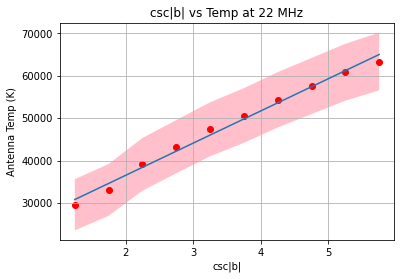

T_extra at 22MHz is 21322.06625 plus/minus 5927.61135
T_g at 22MHz is 7593.48469


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 395577.12it/s]


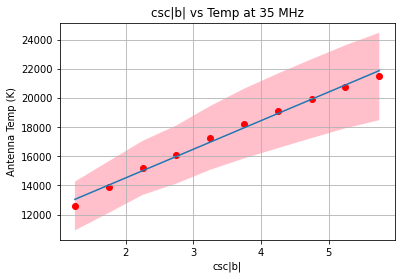

T_extra at 35MHz is 10591.64447 plus/minus 1568.87557
T_g at 35MHz is 1964.19371


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 392946.19it/s]


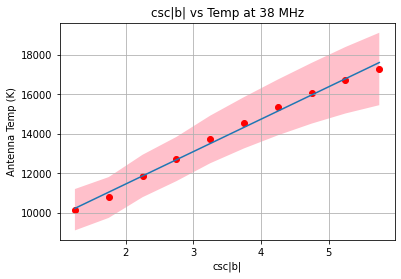

T_extra at 38MHz is 8187.62246 plus/minus 1062.15224
T_g at 38MHz is 1638.48653


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 341917.29it/s]


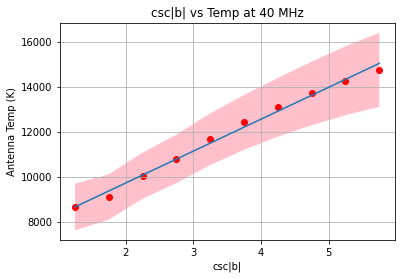

T_extra at 40MHz is 6890.37104 plus/minus 1040.54596
T_g at 40MHz is 1417.49924


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 321524.09it/s]


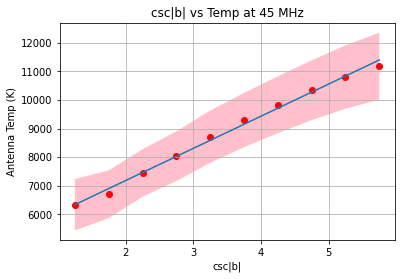

T_extra at 45MHz is 4935.88271 plus/minus 878.42092
T_g at 45MHz is 1123.15394


100%|█████████████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 361879.54it/s]


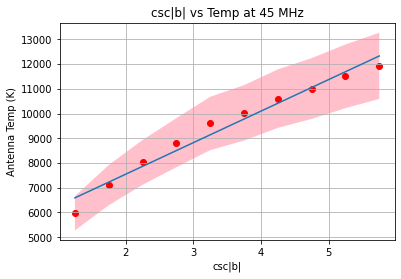

T_extra at 45MHz is 4997.47464 plus/minus 582.87866
T_g at 45MHz is 1275.00203


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 379761.96it/s]


In [ ]:
c_ARCADE=[]
freq_ARCADE=[]
Temp_ARCADE=[]
c_unc_ARCADE=[]
Region="North"
for file in files:
    cscb_Temp_fit_ARCADE(file,Region,True)

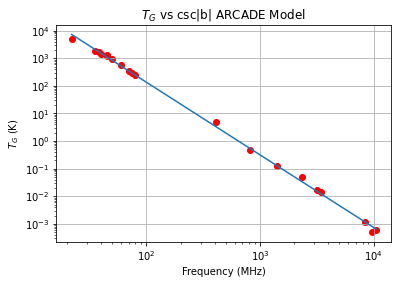

Beta=-2.6327 T_gal=7.3993


In [585]:
#Log and fit
FreqFit = np.log10(freq_ARCADE)
TempFit = np.log10(np.array(Temp_ARCADE))
a, b = np.polyfit(FreqFit,TempFit, 1)
plt.plot(freq_ARCADE,10**(a*FreqFit+b))
plt.grid()
plt.scatter((freq_ARCADE),(Temp_ARCADE),color="red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_G$ (K)")
plt.title("$T_G$ vs csc|b| ARCADE Model")
plt.show()
print("Beta=%.4f"%a,"T_gal=%.4f"%b)

# Holistic Method:
- Plots each Temp according to its own csc|b|, does not average and thus favors latitudes with more points (center)

In [8]:
def cscb_Temp_fit_hol(file,region,graph):
    
    #We first convert the array to a list to go faster
    if file[1]==1420:#1420 MHz is the only one on this list (so far) that is in mK
        File_as_List=(hp.read_map(file[0])/1000).tolist()
    else:
        File_as_List=(hp.read_map(file[0])).tolist()

    #If we have an uncertainty map, we read it and make it a list
    if type(file[4])==str:
        Unc_as_List=(hp.read_map(file[4])).tolist()
    elif type(file[4])==list:
        Unc_as_List=(np.sqrt(file[4][0]**2+file[4][2]**2+(0.01*file[4][1]*np.array(File_as_List))**2)).tolist()

    #If we start in thermo-temp, we make sure to converto to antenna temp:
    
    if file[3]==True:
        convert_to_TA(File_as_List,file[1])
        
        
    #Next, we define our theta coords to bin each value by csc|b|, making sure to go to galactic coords
    npix=int(np.sqrt(len(File_as_List)/12)) #12*NPix^2=total number of pixels
    theta1,phi1=hp.pix2ang(npix,np.arange(len(File_as_List)))
    if file[2]=="E":
        r = hp.rotator.Rotator(coord=['E','G'])
        theta=np.degrees(r(theta1,phi1)[0])
        phi=np.degrees(r(theta1,phi1)[1])+180 #phi rotates oddly.
    if file[2]=="C":
        r = hp.rotator.Rotator(coord=['C','G'])
        theta=np.degrees(r(theta1,phi1)[0])
        phi=np.degrees(r(theta1,phi1)[1])+180
    if file[2]=="G":
        theta=np.degrees(theta1)
        phi=np.degrees(phi1)
    
    #Now we calculate csc|b| for each pixel and add it and its temperature to a list
    Tempvalues=[]
    cscvalues=[]
    uncvals=[]
    Correction_to_45Mhz_RMS=0
    for x in tqdm(range(int(len(File_as_List)))):
        if File_as_List[x]>0 and math.isnan(File_as_List[x])==False: #ignore hp.UNSEEN and 0 pixels
            #Again, we may look at the northern hemisphere, southern, or both
            if region=="North" or region=="All":
                if 90-theta[x]>10:
                    Tempvalues.append(File_as_List[x])
                    csc=1/np.sin(np.radians(abs(90-theta[x])))
                    cscvalues.append(csc)
                    uncvals.append(Unc_as_List[x])
            if region=="South" or region=="All":
                if 90-theta[x]<-10:
                    Tempvalues.append(File_as_List[x])
                    csc=1/np.sin(np.radians(abs(90-theta[x])))
                    cscvalues.append(csc)
                    if file[1]==45 and type(file[4])==list and Correction_to_45Mhz_RMS==0: 
                        #45 MHz has different north and south rms unc
                        Unc_as_List=np.sqrt(np.array(Unc_as_List)**2-300**2+2300**2).tolist()
                        Correction_to_45Mhz_RMS=Correction_to_45Mhz_RMS+1
                    uncvals.append(Unc_as_List[x])
#            if region=="Coldest": ---This was made for the coldest spot but it looks like they don't actually use this---
#                if file[2]=="G":
#                    if 48+15>(90-(theta[x]))>48-15 and 196+15>((phi[x]))>196-15:
#                        Tempvalues.append(File_as_List[x])
#                        csc=1/np.sin(np.radians(abs(90-theta[x])))
#                        cscvalues.append(csc)  
#                elif file[2]=="C" or file[2]=="E":
#                    if 48+15>(90-(theta[x]))>48-15 and 164+15>((phi[x]))>164-15:
#                        Tempvalues.append(File_as_List[x])
#                        csc=1/np.sin(np.radians(abs(90-theta[x])))
#                        cscvalues.append(csc) 
#                uncvals.append(Unc_as_List[x])

#Now we plot!
    Tempvalues = np.array(Tempvalues)
    a, b = np.polyfit(cscvalues,Tempvalues, 1) #fit the data
    if graph==True:
        if type(file[4])==str:
            #No need to worry about std, here as we aren't taking any kind of mean
            plt.fill_between(cscvalues, Tempvalues-uncvals, Tempvalues+uncvals,facecolor="pink")
        plt.scatter(cscvalues,Tempvalues,s=0.1,color="red")

        plt.plot(cscvalues,a*np.array(cscvalues)+b)
        plt.title("csc|b| vs Temp at %s MHz" % file[1])
        plt.xlabel("csc|b|")
        plt.ylabel("Antenna Temp (K)")
        plt.grid()
        plt.show()
    #From the given equation, TA=c+T_g*csc|b| therefore, T_g=a, c=b
    T_g=a
    c=b
    if type(file[4])==str:
        a1,b1,c1 = np.polyfit(cscvalues,np.array(uncvals)**2, 2)
        c_unc=np.sqrt(a1+b1+c1)
    elif type(file[4])==list:
        c_unc=np.sqrt(file[4][0]**2+file[4][2]**2+(0.01*file[4][1]*c)**2)
    print("T_extra at %sMHz is %.5f plus/minus %.5f" % (file[1], c,c_unc))
    print("T_g at %sMHz is %.5f"% (file[1],T_g))
    #Finally we append the values of T_g, c, and freq to make our second scatter plot below
    c_hol.append(c)
    c_unc_hol.append(c_unc)
    freq_hol.append(file[1])
    Temp_hol.append(T_g)

100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 414750.20it/s]


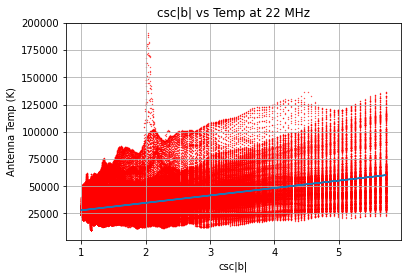

T_extra at 22MHz is 21049.24779 plus/minus 5925.17317
T_g at 22MHz is 6813.73412


 17%|██████████▋                                                   | 135233/786432 [00:00<00:02, 322521.91it/s]


KeyboardInterrupt: 

In [470]:
c_hol=[]
freq_hol=[]
Temp_hol=[]
c_unc_hol=[]
Region="All"
for file in files:
    cscb_Temp_fit_hol(file,Region,True)

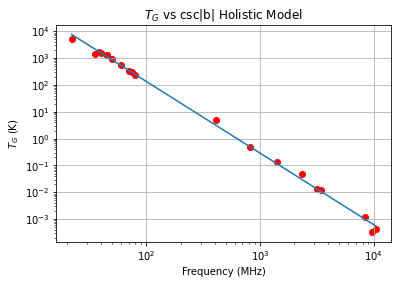

Beta=-2.6668 T_gal=7.4633


In [586]:
FreqFit = np.log10(freq_hol)
TempFit = np.log10(np.array(Temp_hol))
a, b = np.polyfit(FreqFit,TempFit, 1)
plt.plot(freq_hol,10**(a*FreqFit+b))
plt.grid()
plt.scatter((freq_hol),(Temp_hol),color="red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_G$ (K)")
plt.title("$T_G$ vs csc|b| Holistic Model")
plt.show()
print("Beta=%.4f"%a,"T_gal=%.4f"%b)

# Holistic Mean Method
- bin by EACH UNIQUE (up to the hundredths) csc|b| value-- this means that csc|b| towards the poles, with few data points, are as equal as the central ones; top heavy

In [9]:
def cscb_Temp_fit_hol_mean(file,region,graph):

    #We first convert the array to a list to go faster
    if file[1]==1420:#1420 MHz is the only one on this list (so far) that is in mK
        File_as_List=(hp.read_map(file[0])/1000).tolist()
    else:
        File_as_List=(hp.read_map(file[0])).tolist()
        
    #If the file has an uncertainty map, we read it, and turn it into a list
    if type(file[4])==str:
        Unc_as_List=(hp.read_map(file[4])).tolist()
    elif type(file[4])==list:
        Unc_as_List=(np.sqrt(file[4][0]**2+file[4][2]**2+(0.01*file[4][1]*np.array(File_as_List))**2)).tolist()
    
    #If we start in thermo-temp, we make sure to converto to antenna temp:
    if file[3]==True:
        convert_to_TA(File_as_List,file[1])
        
    #Next, we define our theta coords to bin each value by csc|b|, making sure to go to galactic
    npix=int(np.sqrt(len(File_as_List)/12)) #12*NPix^2=total number of pixels
    theta1,phi1=hp.pix2ang(npix,np.arange(len(File_as_List)))
    if file[2]=="E":
        r = hp.rotator.Rotator(coord=['E','G'])
        theta=np.degrees(r(theta1,phi1)[0])
        phi=np.degrees(r(theta1,phi1)[1])+180
    if file[2]=="C":
        r = hp.rotator.Rotator(coord=['C','G'])
        theta=np.degrees(r(theta1,phi1)[0])
        phi=np.degrees(r(theta1,phi1)[1])+180
    if file[2]=="G":
        theta=np.degrees(theta1)
        phi=np.degrees(phi1)
    
    Tempvalues=[]
    cscvalues=[]
    uncvals=[]
    Correction_to_45Mhz_RMS=0
    for x in tqdm(range(int(len(File_as_List)))): #We start off by doing what we did in the previous method
        if File_as_List[x]>0 and math.isnan(File_as_List[x])==False: #ignore hp.UNSEEN and 0 pixels   
            if region=="North" or region=="All":
                if 70>90-theta[x]>10:
                    Tempvalues.append(File_as_List[x])
                    csc=1/np.sin(np.radians(abs(90-theta[x])))
                    cscvalues.append(csc) 
                    uncvals.append(Unc_as_List[x])
            if region=="South" or region=="All":
                if -70<90-theta[x]<-10:
                    Tempvalues.append(File_as_List[x])
                    csc=1/np.sin(np.radians(abs(90-theta[x])))
                    cscvalues.append(csc)
                    if file[1]==45 and type(file[4])==list and Correction_to_45Mhz_RMS==0: #45 MHz has different north and south rms unc
                        Unc_as_List=np.sqrt(np.array(Unc_as_List)**2-300**2+2300**2).tolist()
                        Correction_to_45Mhz_RMS=Correction_to_45Mhz_RMS+1
                    uncvals.append(Unc_as_List[x])
    
    Mean_Temp_List=[]
    Mean_unc_list=[]
    for x in (range(len(cscvalues))):
        cscvalues[x]=round(cscvalues[x], 2) #Now we round each csc value to the hundredths
    cscset=list(set(cscvalues)) #we define a set of all of the UNIQUE csc values
    cscvalues=np.array(cscvalues)
    for x in (cscset):
        DummyTempList=[]
        indices=np.where(cscvalues==x)[0] #we look at what indices the csc values are equal...
        for i in indices:
            DummyTempList.append(Tempvalues[i])
        Mean_Temp_List.append(np.mean(DummyTempList)) #and mean all the ones which are
    #We do the same for uncertainties:
    for x in (cscset):
        DummyUncList=[]
        indices=np.where(cscvalues==x)[0]
        for i in indices:
            DummyUncList.append(uncvals[i])
        Mean_unc_list.append(np.sqrt(np.mean(DummyUncList)**2+np.std(DummyUncList)**2)) #We include a std since we are meaning
    #Due to the fill-between function reading cscvalues in order, and yet, they are all jumbled, we have to order
    #the csc values and their temps/uncertainties:
    Sortedvals=[]
    for x in range(len(cscset)):
        Sortedvals.append([cscset[x],Mean_Temp_List[x],Mean_unc_list[x]])
    Sortedvals=np.array(sorted(Sortedvals)).transpose()
    a, b = np.polyfit(cscset,Mean_Temp_List, 1) #fit the data
    if graph==True:
        plt.fill_between(Sortedvals[0], Sortedvals[1]-Sortedvals[2], Sortedvals[1]+Sortedvals[2],facecolor="pink",interpolate=False)
        #Sortedvals[0]=sorted csc values
        #Sortedvals[1]=sorted Temp values
        #Sortedvals[2]=sorted unc values
        plt.scatter(cscset,Mean_Temp_List,s=3,color="red")
        plt.plot(cscset,a*np.array(cscset)+b)
        plt.title("csc|b| vs Temp at %s MHz" % file[1])
        plt.xlabel("csc|b|")
        plt.ylabel("Antenna Temp (K)")
        plt.grid()
        plt.show()
    #From the given equation, TA=c+T_g*csc|b| therefore, T_g=a, c=b
    T_g=a
    c=b
    if type(file[4])==str:
        a1,b1,c1 = np.polyfit(Sortedvals[0],np.array(Sortedvals[2])**2, 2)
        c_unc=np.sqrt(a1+b1+c1)
    elif type(file[4])==list:
        c_unc=np.sqrt(file[4][0]**2+file[4][2]**2+(0.01*file[4][1]*c)**2)
    print("T_extra at %sMHz is %.5f plus/minus %.5f" % (file[1], c,c_unc))
    print("T_g at %sMHz is %.5f"% (file[1],T_g))
    #Finally we append the values of T_g, c, and freq to make our second scatter plot below
    c_hol_mean.append(c)
    freq_hol_mean.append(file[1])
    Temp_hol_mean.append(T_g)
    c_unc_hol_mean.append(c_unc)

100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 645191.96it/s]


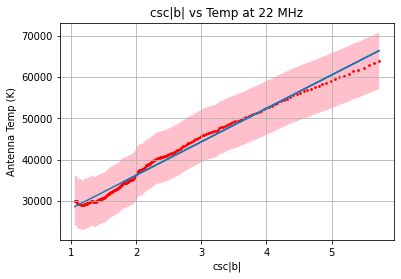

T_extra at 22MHz is 20095.18147 plus/minus 5916.88607
T_g at 22MHz is 8076.04251


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 498689.36it/s]


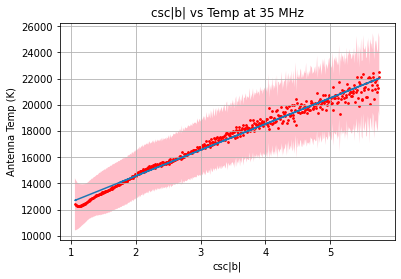

T_extra at 35MHz is 10596.16612 plus/minus 1525.09109
T_g at 35MHz is 1983.61135


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 525119.40it/s]


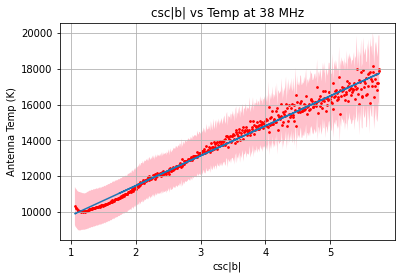

T_extra at 38MHz is 8122.22752 plus/minus 1068.74122
T_g at 38MHz is 1670.83446


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 538349.53it/s]


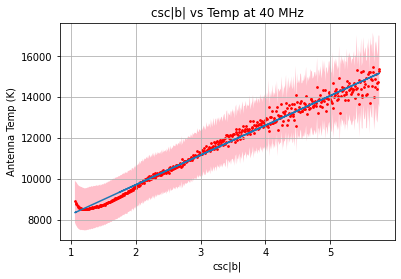

T_extra at 40MHz is 6815.18504 plus/minus 1045.11454
T_g at 40MHz is 1449.95304


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 598468.89it/s]


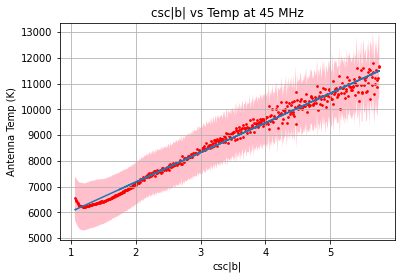

T_extra at 45MHz is 4880.55047 plus/minus 881.63183
T_g at 45MHz is 1147.77425


100%|████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 523864.34it/s]


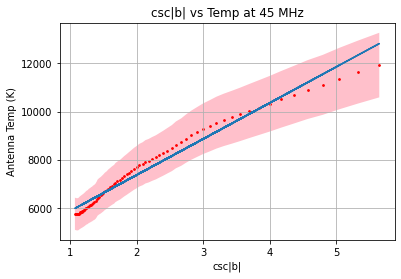

T_extra at 45MHz is 4400.89755 plus/minus 532.61524
T_g at 45MHz is 1490.03616


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 603830.44it/s]


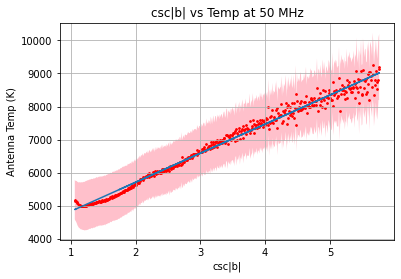

T_extra at 50MHz is 3962.38884 plus/minus 726.49684
T_g at 50MHz is 876.83902


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 604721.14it/s]


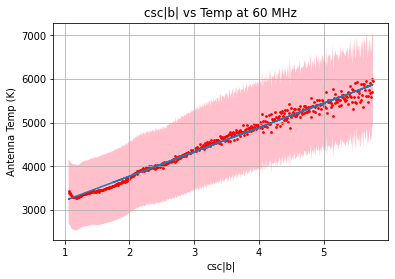

T_extra at 60MHz is 2661.66644 plus/minus 700.75589
T_g at 60MHz is 556.63999


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 581916.70it/s]


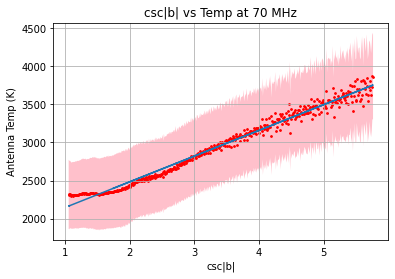

T_extra at 70MHz is 1806.12717 plus/minus 452.13464
T_g at 70MHz is 338.07971


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 590317.41it/s]


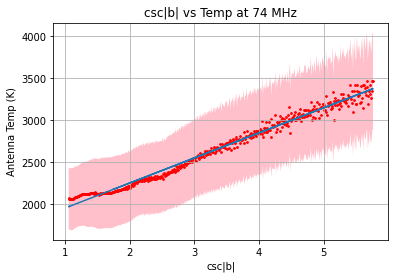

T_extra at 74MHz is 1657.33523 plus/minus 366.41653
T_g at 74MHz is 298.64261


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 601957.03it/s]


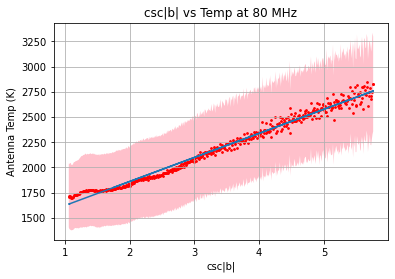

T_extra at 80MHz is 1382.75761 plus/minus 329.84885
T_g at 80MHz is 238.77766


100%|████████████████████████████████████████████████████████████| 3145728/3145728 [00:06<00:00, 508372.90it/s]


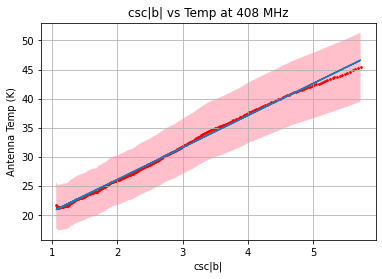

T_extra at 408MHz is 15.14730 plus/minus 3.56853
T_g at 408MHz is 5.48878


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 784060.36it/s]


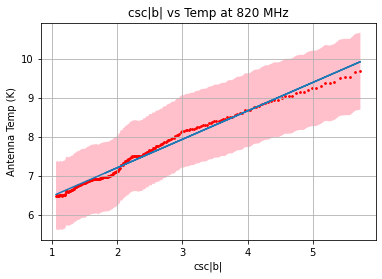

T_extra at 820MHz is 5.74882 plus/minus 0.85380
T_g at 820MHz is 0.72820


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 556334.75it/s]


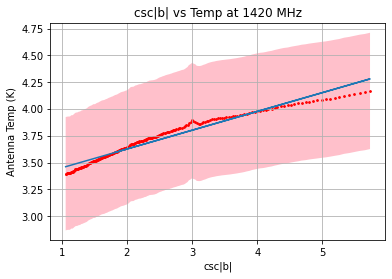

T_extra at 1420MHz is 3.27556 plus/minus 0.52641
T_g at 1420MHz is 0.17541


100%|██████████████████████████████████████████████████████████████| 786432/786432 [00:00<00:00, 931816.89it/s]


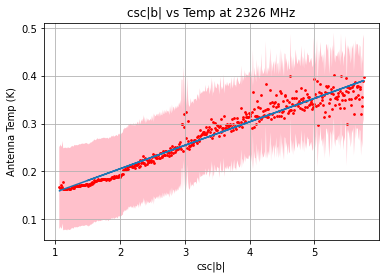

T_extra at 2326MHz is 0.10757 plus/minus 0.08561
T_g at 2326MHz is 0.04908


100%|█████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1807392.61it/s]


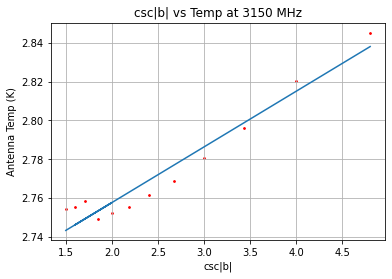

T_extra at 3150MHz is 2.70015 plus/minus 0.00900
T_g at 3150MHz is 0.02874


100%|█████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1497199.85it/s]


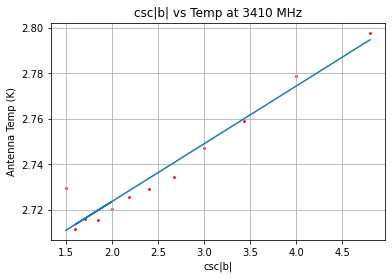

T_extra at 3410MHz is 2.67271 plus/minus 0.00760
T_g at 3410MHz is 0.02543


100%|█████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2650123.79it/s]


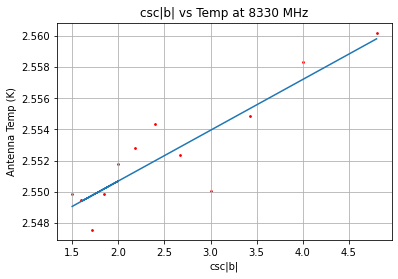

T_extra at 8330MHz is 2.54418 plus/minus 0.01600
T_g at 8330MHz is 0.00325


100%|█████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2438936.57it/s]


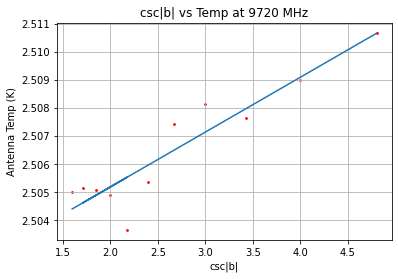

T_extra at 9720MHz is 2.50127 plus/minus 0.00590
T_g at 9720MHz is 0.00196


100%|█████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2068866.71it/s]


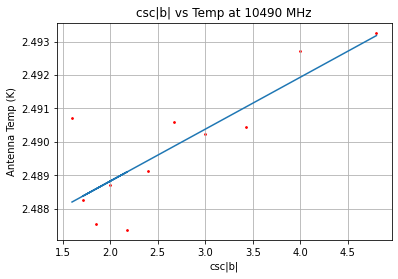

T_extra at 10490MHz is 2.48570 plus/minus 0.00590
T_g at 10490MHz is 0.00156


In [569]:
c_hol_mean=[]
freq_hol_mean=[]
Temp_hol_mean=[]
c_unc_hol_mean=[]
Region="North"
for file in files:
    cscb_Temp_fit_hol_mean(file,Region,True)

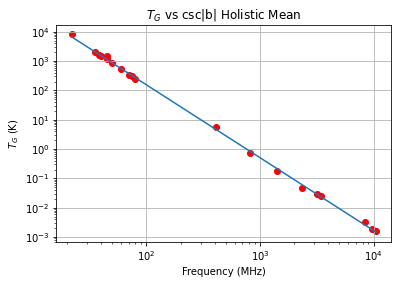

-2.484102994580062 7.159271798493811


In [587]:
FreqFit = np.log10(freq_hol_mean)
TempFit = np.log10(np.array(Temp_hol_mean))
a, b = np.polyfit(FreqFit,TempFit, 1)
plt.plot(freq_hol_mean,10**(a*FreqFit+b))
plt.grid()
plt.scatter((freq_hol_mean),(Temp_hol_mean),color="red")
plt.xlabel("Frequency (MHz)")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("$T_G$ (K)")
plt.title("$T_G$ vs csc|b| Holistic Mean")
plt.show()
print(a,b)

# WIP:
- Now trying to plot extra-galactic graphs

In [10]:
c_all_methods=[]
c_LWA_unc=[]
c_ARCADE=[]
freq_ARCADE=[]
Temp_ARCADE=[]
c_hol=[]
freq_hol=[]
Temp_hol=[]
c_hol_mean=[]
freq_hol_mean=[]
Temp_hol_mean=[]
c_unc_ARCADE=[]
c_unc_hol=[]
c_unc_hol_mean=[]
Region="North"
for file in files:
    cscb_Temp_fit_ARCADE(file,Region,False)
    cscb_Temp_fit_hol(file,Region,False)
    cscb_Temp_fit_hol_mean(file,Region,False)
c_all_methods.append(c_ARCADE)
c_all_methods.append(c_hol)
c_all_methods.append(c_hol_mean)
c_LWA_unc.append(c_unc_ARCADE)
c_LWA_unc.append(c_unc_hol)
c_LWA_unc.append(c_unc_hol_mean)

c_ARCADE=[]
freq_ARCADE=[]
Temp_ARCADE=[]
c_hol=[]
freq_hol=[]
Temp_hol=[]
c_hol_mean=[]
freq_hol_mean=[]
Temp_hol_mean=[]
c_unc_ARCADE=[]
c_unc_hol=[]
c_unc_hol_mean=[]
Region="South"
for file in files:
    cscb_Temp_fit_ARCADE(file,Region,False)
    cscb_Temp_fit_hol(file,Region,False)
    cscb_Temp_fit_hol_mean(file,Region,False)

c_all_methods.append(c_ARCADE)
c_all_methods.append(c_hol)
c_all_methods.append(c_hol_mean)
c_LWA_unc.append(c_unc_ARCADE)
c_LWA_unc.append(c_unc_hol)
c_LWA_unc.append(c_unc_hol_mean)
c_all_methods=np.array(c_all_methods).transpose()
c_LWA_unc=np.array(c_LWA_unc).transpose()

100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 463036.16it/s]


T_extra at 22MHz is 21322.06625 plus/minus 5927.61135
T_g at 22MHz is 7593.48469


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 609969.91it/s]


T_extra at 22MHz is 19818.77378 plus/minus 5914.55488
T_g at 22MHz is 8136.93391


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 554089.44it/s]


T_extra at 22MHz is 20095.18147 plus/minus 5916.88607
T_g at 22MHz is 8076.04251


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 371726.09it/s]


T_extra at 35MHz is 10591.64447 plus/minus 1568.87557
T_g at 35MHz is 1964.19371


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 566111.34it/s]


T_extra at 35MHz is 10110.92078 plus/minus 1675.30294
T_g at 35MHz is 2145.55612


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 556610.38it/s]


T_extra at 35MHz is 10596.16612 plus/minus 1525.09109
T_g at 35MHz is 1983.61135


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 384094.55it/s]


T_extra at 38MHz is 8187.62246 plus/minus 1062.15224
T_g at 38MHz is 1638.48653


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 568320.48it/s]


T_extra at 38MHz is 8066.78402 plus/minus 1059.66647
T_g at 38MHz is 1688.51870


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 548748.13it/s]


T_extra at 38MHz is 8122.22752 plus/minus 1068.74122
T_g at 38MHz is 1670.83446


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 396714.76it/s]


T_extra at 40MHz is 6890.37104 plus/minus 1040.54596
T_g at 40MHz is 1417.49924


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 578678.05it/s]


T_extra at 40MHz is 6836.57653 plus/minus 1049.51304
T_g at 40MHz is 1442.01903


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 567001.45it/s]


T_extra at 40MHz is 6815.18504 plus/minus 1045.11454
T_g at 40MHz is 1449.95304


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 409450.71it/s]


T_extra at 45MHz is 4935.88271 plus/minus 878.42092
T_g at 45MHz is 1123.15394


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 575418.62it/s]


T_extra at 45MHz is 4899.03093 plus/minus 901.52669
T_g at 45MHz is 1140.99805


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 569041.88it/s]


T_extra at 45MHz is 4880.55047 plus/minus 881.63183
T_g at 45MHz is 1147.77425


100%|█████████████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 407278.02it/s]


T_extra at 45MHz is 4997.47464 plus/minus 582.87866
T_g at 45MHz is 1275.00203


100%|█████████████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 553812.68it/s]


T_extra at 45MHz is 4362.54069 plus/minus 529.45029
T_g at 45MHz is 1499.55765


100%|█████████████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 543298.53it/s]


T_extra at 45MHz is 4400.89755 plus/minus 532.61524
T_g at 45MHz is 1490.03616


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 398191.85it/s]


T_extra at 50MHz is 4000.56085 plus/minus 707.78467
T_g at 50MHz is 859.10981


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 570719.58it/s]


T_extra at 50MHz is 3980.41473 plus/minus 693.08230
T_g at 50MHz is 870.29998


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 579470.07it/s]


T_extra at 50MHz is 3962.38884 plus/minus 726.49684
T_g at 50MHz is 876.83902


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 393976.51it/s]


T_extra at 60MHz is 2682.10054 plus/minus 702.31350
T_g at 60MHz is 546.27292


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 573246.80it/s]


T_extra at 60MHz is 2660.65026 plus/minus 729.11206
T_g at 60MHz is 556.63026


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 559730.49it/s]


T_extra at 60MHz is 2661.66644 plus/minus 700.75589
T_g at 60MHz is 556.63999


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 417800.44it/s]


T_extra at 70MHz is 1813.62751 plus/minus 450.69679
T_g at 70MHz is 333.70019


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 430694.71it/s]


T_extra at 70MHz is 1884.83808 plus/minus 445.62953
T_g at 70MHz is 311.06016


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 525016.43it/s]


T_extra at 70MHz is 1806.12717 plus/minus 452.13464
T_g at 70MHz is 338.07971


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 391427.69it/s]


T_extra at 74MHz is 1659.60311 plus/minus 363.71249
T_g at 74MHz is 295.78768


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 555529.43it/s]


T_extra at 74MHz is 1714.93820 plus/minus 366.88381
T_g at 74MHz is 278.77082


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 563587.57it/s]


T_extra at 74MHz is 1657.33523 plus/minus 366.41653
T_g at 74MHz is 298.64261


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 387135.67it/s]


T_extra at 80MHz is 1383.01940 plus/minus 325.21586
T_g at 80MHz is 237.05681


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 534752.88it/s]


T_extra at 80MHz is 1436.20445 plus/minus 325.57332
T_g at 80MHz is 220.50063


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 412057.21it/s]


T_extra at 80MHz is 1382.75761 plus/minus 329.84885
T_g at 80MHz is 238.77766


100%|█████████████████████████████████████████████████████████████████████| 3145728/3145728 [00:08<00:00, 354148.19it/s]


T_extra at 408MHz is 15.47685 plus/minus 3.58264
T_g at 408MHz is 5.32278


100%|█████████████████████████████████████████████████████████████████████| 3145728/3145728 [00:06<00:00, 519836.90it/s]


T_extra at 408MHz is 14.99463 plus/minus 3.56208
T_g at 408MHz is 5.52808


100%|█████████████████████████████████████████████████████████████████████| 3145728/3145728 [00:06<00:00, 475767.11it/s]


T_extra at 408MHz is 15.14730 plus/minus 3.56853
T_g at 408MHz is 5.48878


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 498672.40it/s]


T_extra at 820MHz is 5.86216 plus/minus 0.85657
T_g at 820MHz is 0.68207


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 687049.91it/s]


T_extra at 820MHz is 5.67695 plus/minus 0.85207
T_g at 820MHz is 0.74978


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 733381.94it/s]


T_extra at 820MHz is 5.74882 plus/minus 0.85380
T_g at 820MHz is 0.72820


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 372038.07it/s]


T_extra at 1420MHz is 3.32601 plus/minus 0.52720
T_g at 1420MHz is 0.15520


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 509771.31it/s]


T_extra at 1420MHz is 3.23159 plus/minus 0.52573
T_g at 1420MHz is 0.18818


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 515849.38it/s]


T_extra at 1420MHz is 3.27556 plus/minus 0.52641
T_g at 1420MHz is 0.17541


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1243356.35it/s]


T_extra at 3150MHz is 2.68843 plus/minus 0.00900
T_g at 3150MHz is 0.03244


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1983818.61it/s]


T_extra at 3150MHz is 2.69621 plus/minus 0.00900
T_g at 3150MHz is 0.02946


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1360889.51it/s]


T_extra at 3150MHz is 2.70015 plus/minus 0.00900
T_g at 3150MHz is 0.02874


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1231943.96it/s]


T_extra at 3410MHz is 2.66343 plus/minus 0.00760
T_g at 3410MHz is 0.02819


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2374659.40it/s]


T_extra at 3410MHz is 2.66857 plus/minus 0.00760
T_g at 3410MHz is 0.02642


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2286584.19it/s]


T_extra at 3410MHz is 2.67271 plus/minus 0.00760
T_g at 3410MHz is 0.02543


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1577678.69it/s]


T_extra at 8330MHz is 2.54369 plus/minus 0.01600
T_g at 8330MHz is 0.00346


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1999208.98it/s]


T_extra at 8330MHz is 2.54430 plus/minus 0.01600
T_g at 8330MHz is 0.00317


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2461299.31it/s]


T_extra at 8330MHz is 2.54418 plus/minus 0.01600
T_g at 8330MHz is 0.00325


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1938745.39it/s]


T_extra at 9720MHz is 2.50113 plus/minus 0.00590
T_g at 9720MHz is 0.00202


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1549224.71it/s]


T_extra at 9720MHz is 2.50101 plus/minus 0.00590
T_g at 9720MHz is 0.00204


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2504840.96it/s]


T_extra at 9720MHz is 2.50127 plus/minus 0.00590
T_g at 9720MHz is 0.00196


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1844917.22it/s]


T_extra at 10490MHz is 2.48531 plus/minus 0.00590
T_g at 10490MHz is 0.00167


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2714897.15it/s]


T_extra at 10490MHz is 2.48518 plus/minus 0.00590
T_g at 10490MHz is 0.00169


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2413354.91it/s]

T_extra at 10490MHz is 2.48570 plus/minus 0.00590
T_g at 10490MHz is 0.00156



100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 520396.52it/s]


T_extra at 22MHz is 22714.52083 plus/minus 5940.52806
T_g at 22MHz is 5148.19624


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 746985.51it/s]


T_extra at 22MHz is 22036.60521 plus/minus 5934.14104
T_g at 22MHz is 5392.11548


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 733064.61it/s]


T_extra at 22MHz is 21847.12555 plus/minus 5932.38925
T_g at 22MHz is 5456.28149


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 471997.86it/s]


T_extra at 35MHz is 9423.62306 plus/minus 1414.81544
T_g at 35MHz is 1799.29710


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 623537.68it/s]


T_extra at 35MHz is 10451.98789 plus/minus 1444.87967
T_g at 35MHz is 1463.45794


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 621607.77it/s]


T_extra at 35MHz is 9216.79352 plus/minus 1427.69598
T_g at 35MHz is 1853.59785


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 418390.00it/s]


T_extra at 38MHz is 6713.78543 plus/minus 744.09843
T_g at 38MHz is 1677.18619


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 589049.44it/s]


T_extra at 38MHz is 6590.41734 plus/minus 754.80316
T_g at 38MHz is 1734.90055


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 566638.82it/s]


T_extra at 38MHz is 6775.25258 plus/minus 784.98271
T_g at 38MHz is 1676.15722


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 478646.77it/s]


T_extra at 40MHz is 5517.84905 plus/minus 687.44850
T_g at 40MHz is 1487.44564


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 663306.48it/s]


T_extra at 40MHz is 5280.10586 plus/minus 684.66432
T_g at 40MHz is 1581.54263


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 670315.93it/s]


T_extra at 40MHz is 5569.24653 plus/minus 712.25838
T_g at 40MHz is 1488.70816


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 476195.86it/s]


T_extra at 45MHz is 3780.74692 plus/minus 625.81063
T_g at 45MHz is 1214.35207


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 639428.65it/s]


T_extra at 45MHz is 3581.16234 plus/minus 611.08839
T_g at 45MHz is 1291.86004


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 647713.02it/s]


T_extra at 45MHz is 3794.66936 plus/minus 632.54104
T_g at 45MHz is 1222.49354


100%|█████████████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 305647.21it/s]

T_extra at 45MHz is 4091.59564 plus/minus 507.35742
T_g at 45MHz is 1265.66812



100%|█████████████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 400748.84it/s]


T_extra at 45MHz is 3924.79862 plus/minus 494.00450
T_g at 45MHz is 1326.89765


100%|█████████████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 402138.73it/s]


T_extra at 45MHz is 3824.38730 plus/minus 486.06520
T_g at 45MHz is 1357.70265


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 346613.32it/s]


T_extra at 50MHz is 3139.73207 plus/minus 556.89309
T_g at 50MHz is 922.53620


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 533048.73it/s]


T_extra at 50MHz is 3083.94483 plus/minus 622.51265
T_g at 50MHz is 948.51668


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 556111.99it/s]


T_extra at 50MHz is 3130.10618 plus/minus 534.63567
T_g at 50MHz is 932.78687


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 396902.94it/s]


T_extra at 60MHz is 2381.95106 plus/minus 492.74748
T_g at 60MHz is 549.62477


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 619500.76it/s]


T_extra at 60MHz is 2407.94674 plus/minus 547.99027
T_g at 60MHz is 545.58146


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 621014.07it/s]


T_extra at 60MHz is 2377.16961 plus/minus 491.08180
T_g at 60MHz is 555.38504


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 469317.13it/s]


T_extra at 70MHz is 1620.22882 plus/minus 383.20297
T_g at 70MHz is 337.94981


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 662201.09it/s]


T_extra at 70MHz is 1649.87406 plus/minus 384.36739
T_g at 70MHz is 332.14523


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 656083.43it/s]


T_extra at 70MHz is 1649.51960 plus/minus 400.59410
T_g at 70MHz is 333.19179


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 471300.27it/s]


T_extra at 74MHz is 1464.97617 plus/minus 374.15176
T_g at 74MHz is 304.19740


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 680961.98it/s]


T_extra at 74MHz is 1476.61879 plus/minus 365.55538
T_g at 74MHz is 304.13216


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 615548.28it/s]


T_extra at 74MHz is 1491.96477 plus/minus 390.43456
T_g at 74MHz is 299.89230


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 493610.87it/s]


T_extra at 80MHz is 1241.42276 plus/minus 335.79930
T_g at 80MHz is 246.11819


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 662024.06it/s]


T_extra at 80MHz is 1261.94386 plus/minus 340.98545
T_g at 80MHz is 241.81328


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 560859.14it/s]


T_extra at 80MHz is 1252.58225 plus/minus 342.19809
T_g at 80MHz is 244.97583


100%|█████████████████████████████████████████████████████████████████████| 3145728/3145728 [00:09<00:00, 318956.03it/s]


T_extra at 408MHz is 14.71940 plus/minus 3.55058
T_g at 408MHz is 4.80288


100%|█████████████████████████████████████████████████████████████████████| 3145728/3145728 [00:05<00:00, 541435.42it/s]


T_extra at 408MHz is 14.46681 plus/minus 3.54018
T_g at 408MHz is 4.92023


100%|█████████████████████████████████████████████████████████████████████| 3145728/3145728 [00:06<00:00, 458767.93it/s]


T_extra at 408MHz is 14.48353 plus/minus 3.54087
T_g at 408MHz is 4.91244


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 689234.33it/s]


T_extra at 820MHz is 6.31327 plus/minus 0.86804
T_g at 820MHz is 0.47710


100%|██████████████████████████████████████████████████████████████████████| 786432/786432 [00:00<00:00, 1002849.32it/s]


T_extra at 820MHz is 6.26803 plus/minus 0.86685
T_g at 820MHz is 0.49321


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:00<00:00, 930999.22it/s]


T_extra at 820MHz is 6.26317 plus/minus 0.86673
T_g at 820MHz is 0.49475


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 377523.19it/s]


T_extra at 1420MHz is 3.39062 plus/minus 0.52823
T_g at 1420MHz is 0.12950


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 492477.26it/s]


T_extra at 1420MHz is 3.38388 plus/minus 0.52812
T_g at 1420MHz is 0.13224


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 441724.15it/s]


T_extra at 1420MHz is 3.37134 plus/minus 0.52792
T_g at 1420MHz is 0.13620


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1687388.93it/s]


T_extra at 3150MHz is 2.72491 plus/minus 0.00900
T_g at 3150MHz is 0.01630


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1954330.64it/s]


T_extra at 3150MHz is 2.73189 plus/minus 0.00900
T_g at 3150MHz is 0.01382


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1800070.12it/s]


T_extra at 3150MHz is 2.73044 plus/minus 0.00900
T_g at 3150MHz is 0.01432


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1259644.33it/s]


T_extra at 3410MHz is 2.69492 plus/minus 0.00760
T_g at 3410MHz is 0.01440


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1365649.38it/s]


T_extra at 3410MHz is 2.69985 plus/minus 0.00760
T_g at 3410MHz is 0.01221


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2062904.56it/s]


T_extra at 3410MHz is 2.70048 plus/minus 0.00760
T_g at 3410MHz is 0.01226


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1785106.94it/s]


T_extra at 8330MHz is 2.54751 plus/minus 0.01600
T_g at 8330MHz is 0.00113


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1187329.70it/s]


T_extra at 8330MHz is 2.54689 plus/minus 0.01600
T_g at 8330MHz is 0.00124


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1914831.61it/s]


T_extra at 8330MHz is 2.54617 plus/minus 0.01600
T_g at 8330MHz is 0.00145


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2323697.36it/s]


T_extra at 9720MHz is 2.50704 plus/minus 0.00590
T_g at 9720MHz is 0.00050


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1562942.98it/s]


T_extra at 9720MHz is 2.50738 plus/minus 0.00590
T_g at 9720MHz is 0.00033


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2485034.12it/s]


T_extra at 9720MHz is 2.50759 plus/minus 0.00590
T_g at 9720MHz is 0.00030


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2282129.28it/s]


T_extra at 10490MHz is 2.48859 plus/minus 0.00590
T_g at 10490MHz is 0.00059


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2309122.20it/s]


T_extra at 10490MHz is 2.48888 plus/minus 0.00590
T_g at 10490MHz is 0.00044


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2604062.63it/s]

T_extra at 10490MHz is 2.48905 plus/minus 0.00590
T_g at 10490MHz is 0.00042


In [11]:
std_list=[]
freq_list=[]
temp_list=[]
unc_list=[]
for i in range(len(c_all_methods)):
    temp_list.append(np.mean(c_all_methods[i]))
    std_list.append(np.std(c_all_methods[i]))
    freq_list.append(files[i][1])
temp_list=convert_to_TT(temp_list,freq_list)
for i in range(len(temp_list)):
    if type(files[i][4])==list:
        unc=np.sqrt(files[i][4][0]**2+(files[i][4][1]*0.01*temp_list[i])**2+files[i][4][2]**2+std_list[i]**2)
        print(temp_list[i],unc)
        unc_list.append(unc)
    elif type(files[i][4])==str:
        Mean_LWA_unc=np.mean(c_LWA_unc[i])
        unc=np.sqrt(Mean_LWA_unc**2+std_list[i]**2)
        print(temp_list[i],unc)
        unc_list.append(unc)

21305.71278425351 6017.996810981195
10065.190151042878 1607.9332353084828
7409.349136447017 1161.7218146892947
6151.5566360565435 1117.7511900779573
4312.008201339006 962.8740600264073
4266.950151535198 650.2353485392154
3549.525783360558 772.3947769171613
2528.5822159576724 626.5227496565054
1737.3708851996284 431.46110839871096
1577.5744885562776 384.89427168023207
1326.3236411403138 341.97408390759733
14.891207873283669 3.576296961981958
6.04172211305199 0.9010378556990439
3.3637923449302782 0.5311014944156837
2.7869092495782586 0.01972110242591359
2.7643476014855755 0.017198220443955393
2.740487967100726 0.016066888421504263
2.7308425168820034 0.006666568840388454
2.7311116410707794 0.006149345627777625


In [15]:
temp_list[-6]=temp_list[-6]-2.625

In [18]:
print(temp_list)
#fitting
def func(freq,a,b,c):
    return np.log10(a+b*(freq/1000)**(-c))

[21305.71278425351, 10065.190151042878, 7409.349136447017, 6151.5566360565435, 4312.008201339006, 4266.950151535198, 3549.525783360558, 2528.5822159576724, 1737.3708851996284, 1577.5744885562776, 1326.3236411403138, 14.891207873283669, 6.04172211305199, 3.3637923449302782, 2.7869092495782586, 2.7643476014855755, 2.740487967100726, 2.7308425168820034, 2.7311116410707794]


[2.70147909 1.77151152 2.54184237]


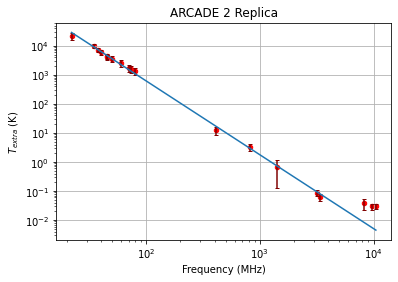

In [17]:
FreqFit = (freq_list)
TempFit = (np.array(temp_list))
a, b = np.polyfit(FreqFit,TempFit, 1)
plt.grid()
constants=curve_fit(func,freq_list,np.log10(temp_list),p0=[2.725,10,2.5],bounds=(0,np.inf))[0]
plt.errorbar(x=freq_list,y=temp_list-constants[0],yerr=unc_list,fmt="none",color="maroon",capsize=2)
plt.scatter((freq_list),(np.array(temp_list)-constants[0]),color="red",s=20)
plt.plot((freq_list),(constants[1]*(np.array(freq_list)/1000)**(-constants[2])))
print(constants)
plt.xlabel("Frequency (MHz)")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("$T_{extra}$ (K)")
plt.title("ARCADE 2 Replica")
plt.show()

In [ ]:
np.sqrt(np.diag(pcov))

FITS_rec([(   0,  61.08273, -11.19187 , 0.39829606,  9.448021 , 1.010223  , 0.09920422, 0.46864563, 0.31687963, 0.00168712),
          (   1,  63.78427, -11.529214, 1.0280687 ,  9.9742   , 0.7270795 , 0.1047291 , 0.69496155, 0.22806516, 0.00250186),
          (   2,  60.15658,  -8.682524, 0.67066395, 16.891596 , 0.80079126, 0.17736176, 0.48370084, 0.25118655, 0.00174132),
          ...,
          (6141, 211.42781, -49.880856, 0.7380472 ,  3.1967216, 0.90974087, 0.03356558, 0.6246833 , 0.28536108, 0.00224886),
          (6142, 211.27927, -54.446735, 1.0295271 ,  1.7322103, 0.75490624, 0.01818821, 0.4061522 , 0.23679364, 0.00146215),
          (6143, 209.10335, -52.11479 , 1.1106532 ,  2.7754207, 0.7199492 , 0.02914192, 0.54114044, 0.22582857, 0.00194811)],
         dtype=(numpy.record, [('PIXEL', '>i4'), ('GAL_LON', '>f4'), ('GAL_LAT', '>f4'), ('WEIGHT', '>f4'), ('C158_FLUX', '>f4'), ('C158_SIGMA', '>f4'), ('C158_PSIG', '>f4'), ('N205_FLUX', '>f4'), ('N205_SIGMA', '>f4'), ('N205_PSIG', 